In [1]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from re_forecast.data.get_data import get_rte_units_names, get_rte_data
from re_forecast.preprocessing.datetime import (construct_time_consistent_df, plot_consecutive_time_periods, plot_missing_dates_repartition)

# Preprocessing step 2

The goals of this notebooks are :  
- Quantify the missing values among the wind offshore generation units, find the generation unit with the less missing datas  
- Find out how to deal with missing values in time series  
- Try out multiple techniques of imputation for the choosen generation unit  
- Choose the best technique of imputation with the best parameters  
- Package all the functions and construct the impute missing values module

## Qantify missing values among wind offshore generation units

In [2]:
#########################################################
# 1/ Download all the generation units for ressource n2 #
#########################################################

# Set the parameters
ressource_nb = 2
start_date = "2022-06-01 00:00:00" # Note: don't modify the start & end date for following requests
end_date = "2024-03-01 00:00:00"
eic_code = None
production_type = None
production_subtype = None

# Download generation data: don't forget to set the api_delay_bypass to true in the params in this case,
# and to reset it to false if you know that you will download fresh data from the api
ressource_2_gen_data = get_rte_data(ressource_nb = ressource_nb,
                                    start_date = start_date,
                                    end_date = end_date,
                                    eic_code = eic_code,
                                    production_type = production_type,
                                    production_subtype = production_subtype)

################################################
# 2/ Download the units names for ressource n2 #
################################################

ressource_2_units = get_rte_units_names(ressource_nb = ressource_nb)

In [3]:
# Show units names and values for wind offshore generation type
wind_offshore_units = ressource_2_units.loc[ressource_2_units["production_type"] == "WIND_OFFSHORE", :]
wind_offshore_gen_data = ressource_2_gen_data.loc[ressource_2_gen_data["eic_code"].isin(wind_offshore_units["eic_code"]), :]

display(wind_offshore_units)
display(wind_offshore_gen_data)

,eic_code,name,production_type
3,17W0000014455651,BANC DE GUERANDE 1,WIND_OFFSHORE
4,17W000001445567Y,BANC DE GUERANDE 2,WIND_OFFSHORE
5,17W000001445569U,FECAMP 1,WIND_OFFSHORE
6,17W0000014455708,FECAMP 2,WIND_OFFSHORE
140,17W100P100P0842Y,A1 DE PARC EOLIEN EN MER DE LA BAIE DE ST-BRIEUC,WIND_OFFSHORE
142,17W100P100P3382R,A2 DE PARC EOLIEN EN MER DE LA BAIE DE ST-BRIEUC,WIND_OFFSHORE


,start_date,end_date,updated_date,value,eic_code
788396,2023-03-03T22:00:00+01:00,2023-03-03T23:00:00+01:00,2023-03-03T23:25:47+01:00,107.0,17W0000014455651
788397,2023-03-03T23:00:00+01:00,2023-03-04T00:00:00+01:00,2023-03-04T00:23:08+01:00,136.0,17W0000014455651
788398,2023-03-04T00:00:00+01:00,2023-03-04T01:00:00+01:00,2023-03-04T01:24:06+01:00,127.0,17W0000014455651
788399,2023-03-04T01:00:00+01:00,2023-03-04T02:00:00+01:00,2023-03-07T14:05:05+01:00,109.0,17W0000014455651
788400,2023-03-04T02:00:00+01:00,2023-03-04T03:00:00+01:00,2023-03-04T03:23:02+01:00,85.0,17W0000014455651
...,...,...,...,...,...
1886295,2024-02-29T19:00:00+01:00,2024-02-29T20:00:00+01:00,2024-02-29T20:26:10+01:00,52.0,17W100P100P3382R
1886296,2024-02-29T20:00:00+01:00,2024-02-29T21:00:00+01:00,2024-02-29T21:23:57+01:00,47.0,17W100P100P3382R
1886297,2024-02-29T21:00:00+01:00,2024-02-29T22:00:00+01:00,2024-02-29T22:28:58+01:00,51.0,17W100P100P3382R
1886298,2024-02-29T22:00:00+01:00,2024-02-29T23:00:00+01:00,2024-02-29T23:24:01+01:00,55.0,17W100P100P3382R


Missing values analysis for unit BANC DE GUERANDE 1
The dataset contain 8714 values


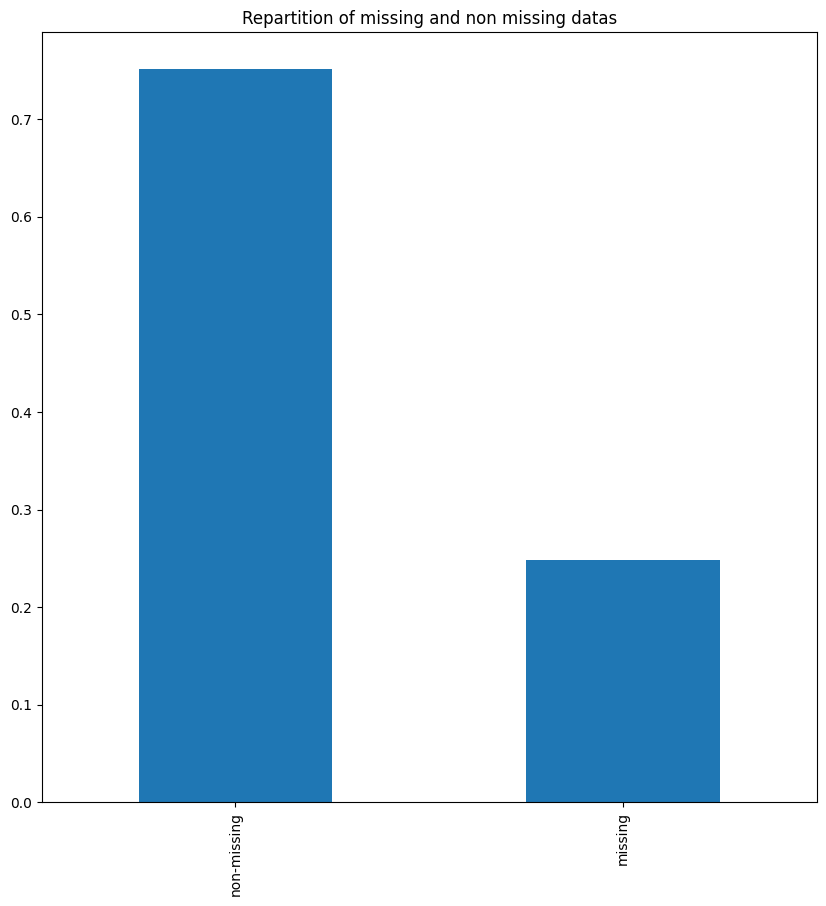

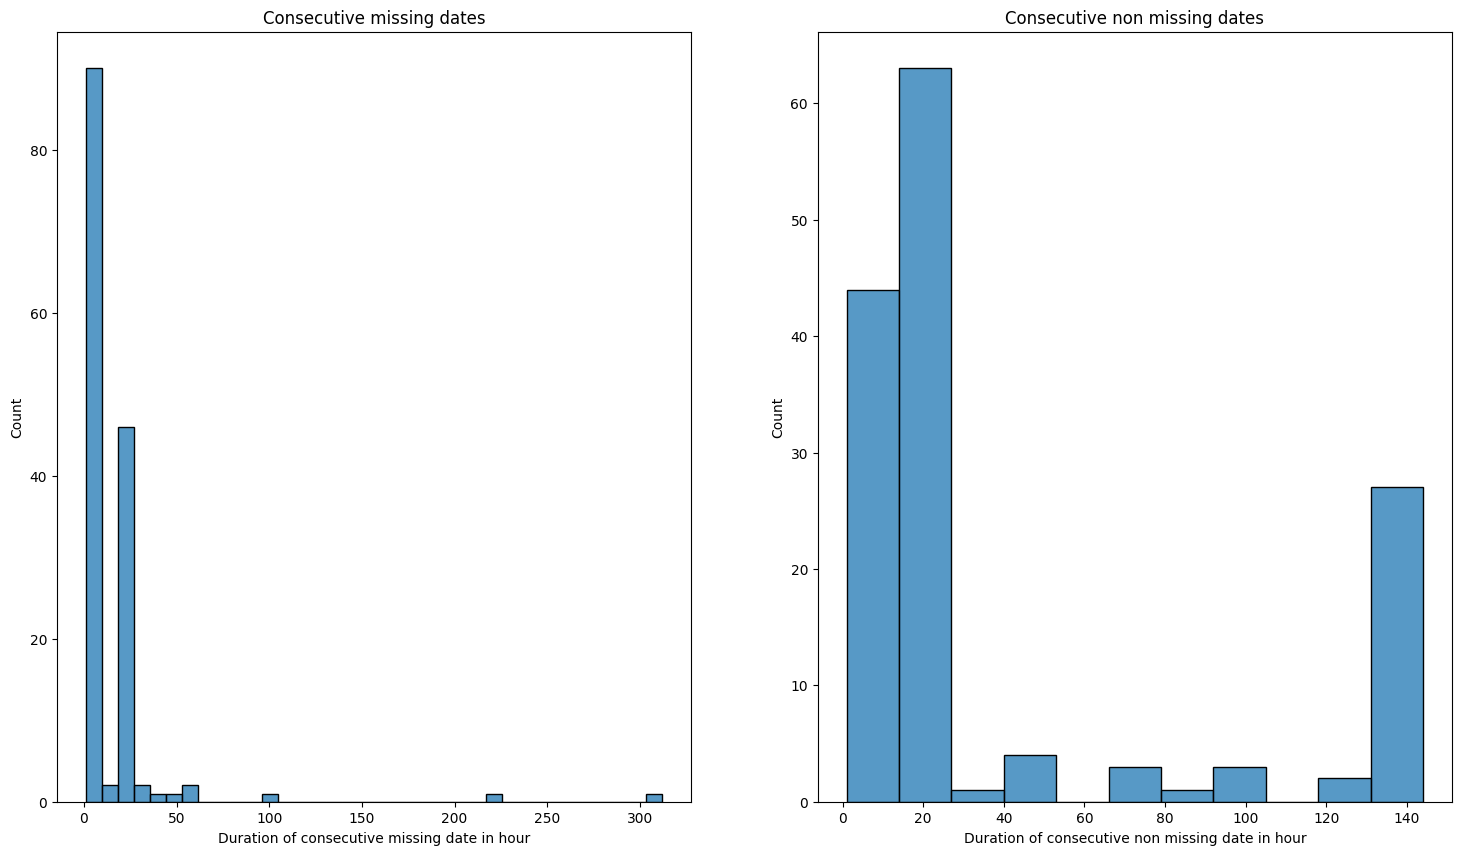

Missing values analysis for unit BANC DE GUERANDE 2
The dataset contain 8716 values


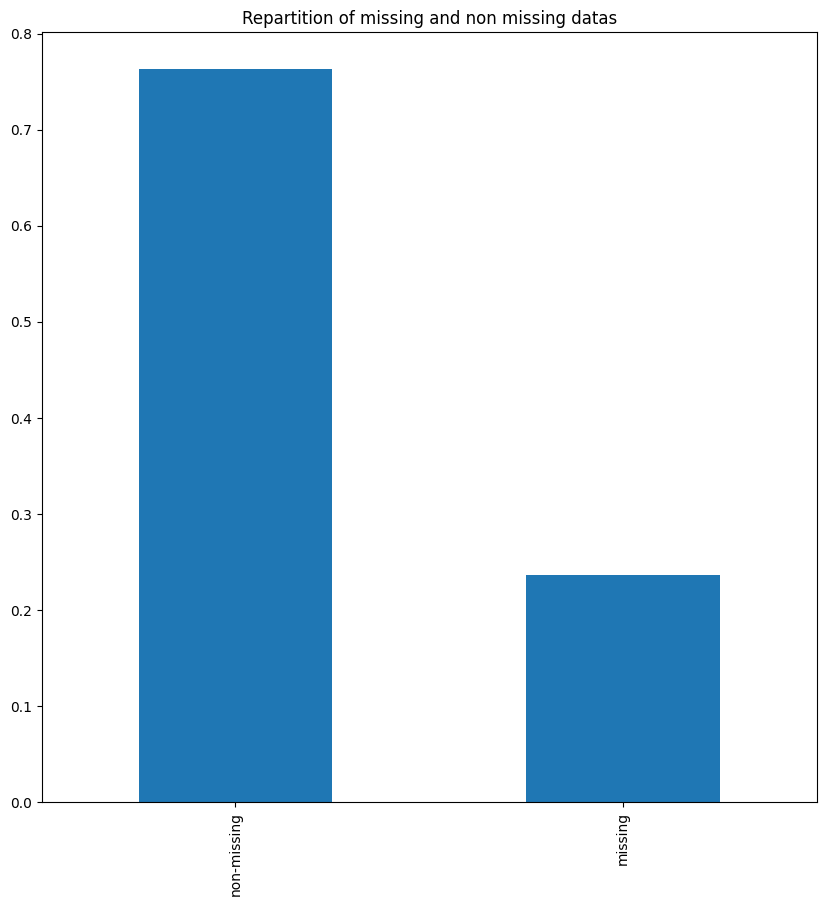

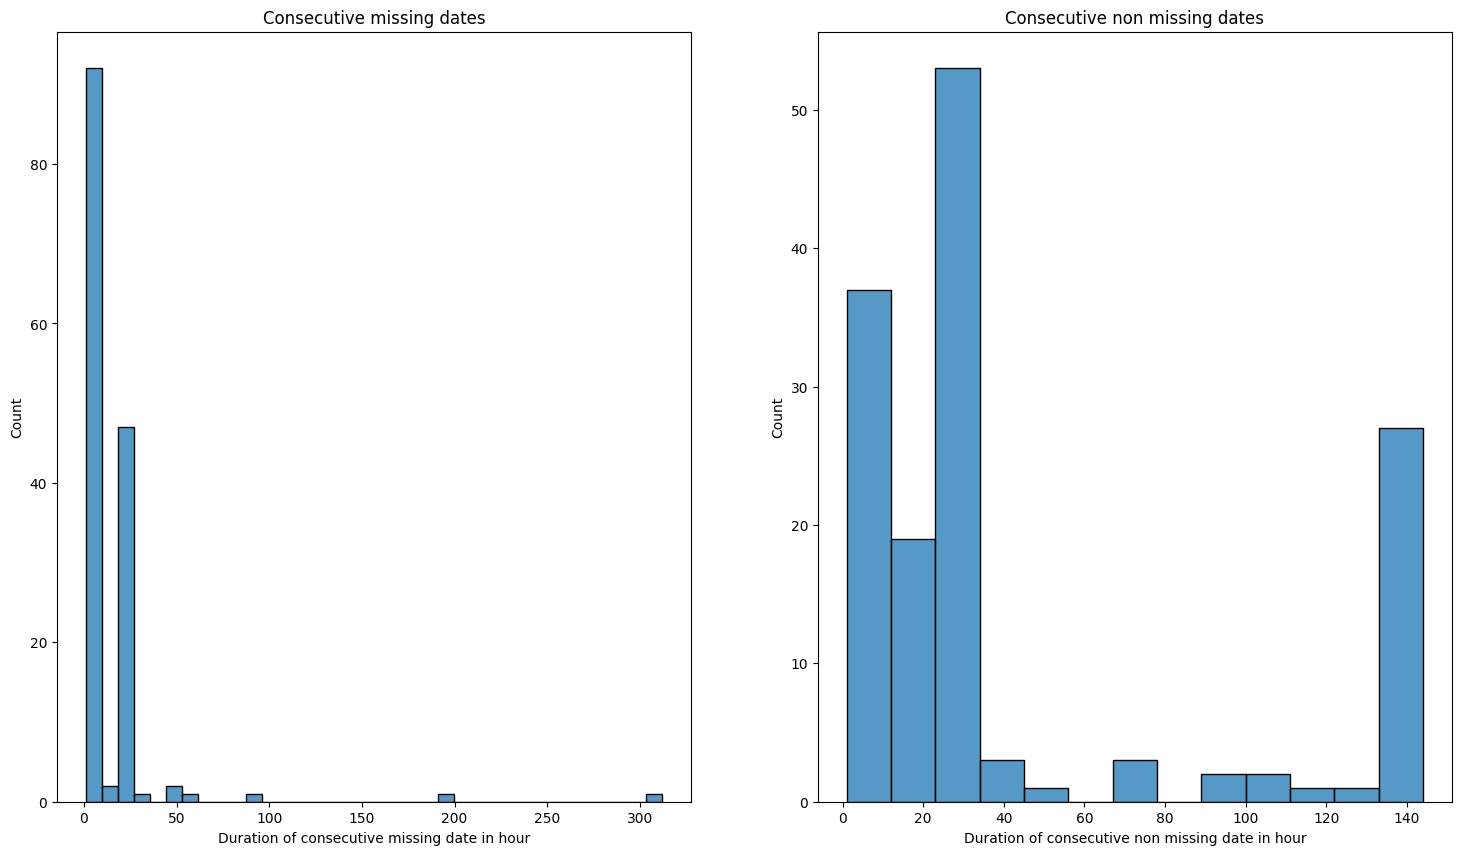

Missing values analysis for unit FECAMP 1
The dataset contain 2880 values


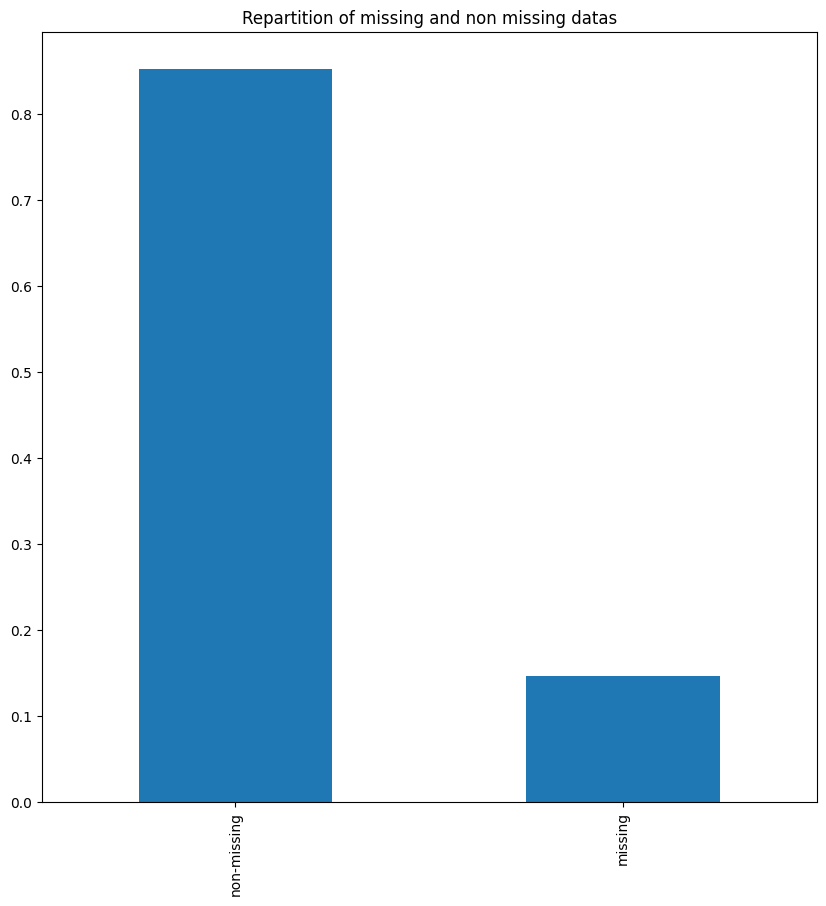

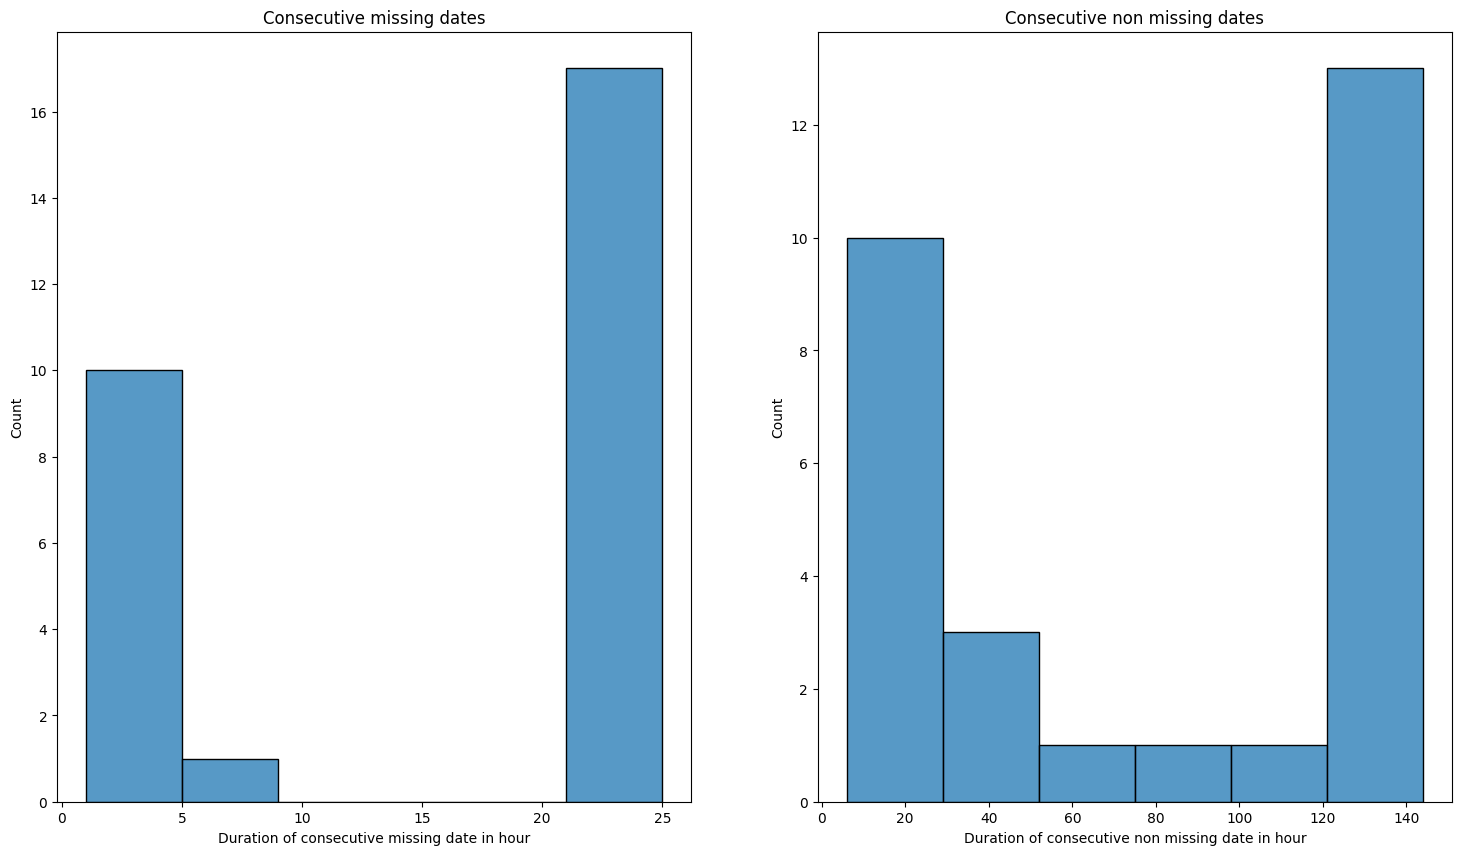

Missing values analysis for unit FECAMP 2
The dataset contain 2880 values


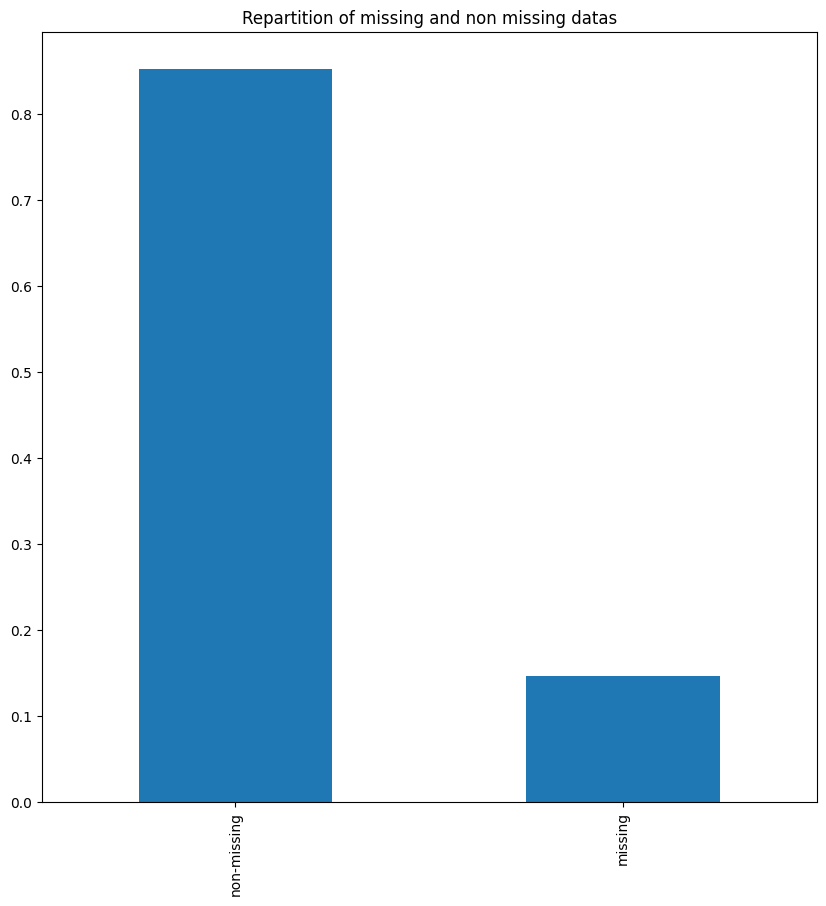

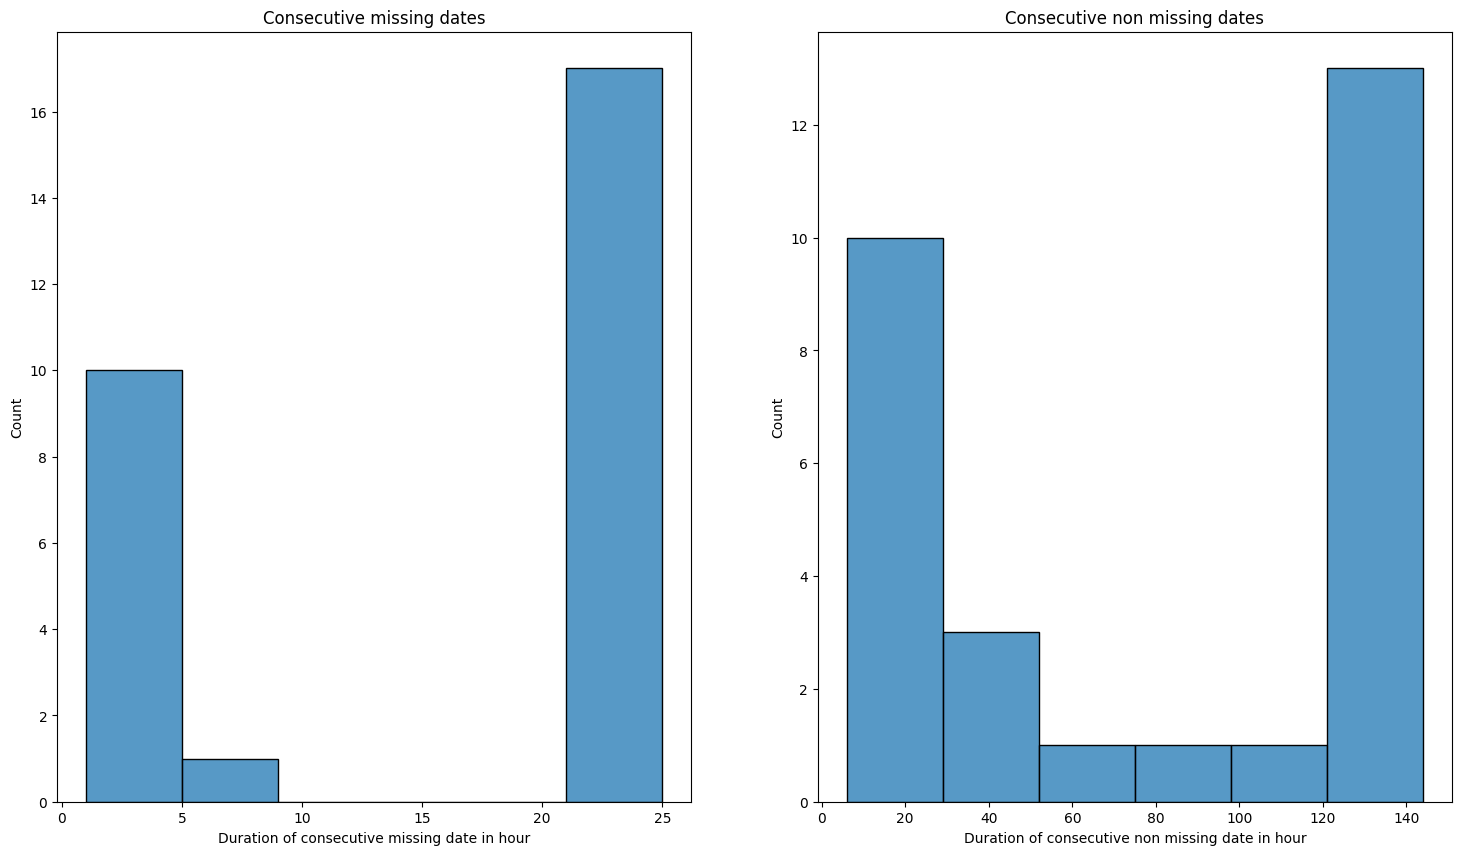

Missing values analysis for unit A1 DE PARC EOLIEN EN MER DE LA BAIE DE ST-BRIEUC
The dataset contain 6199 values


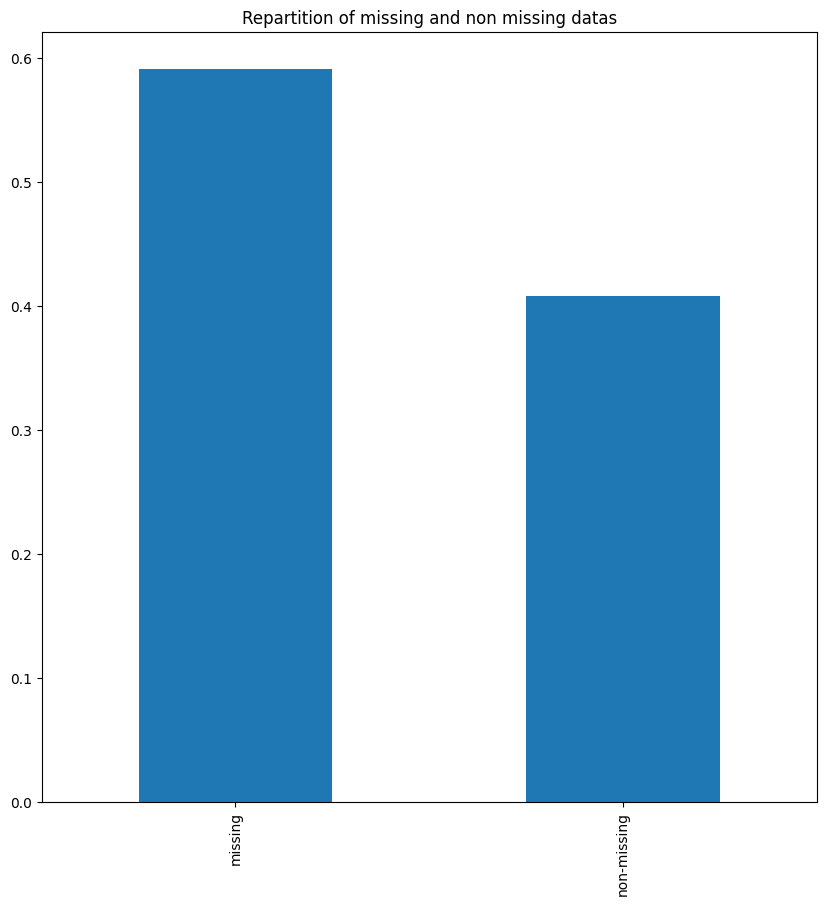

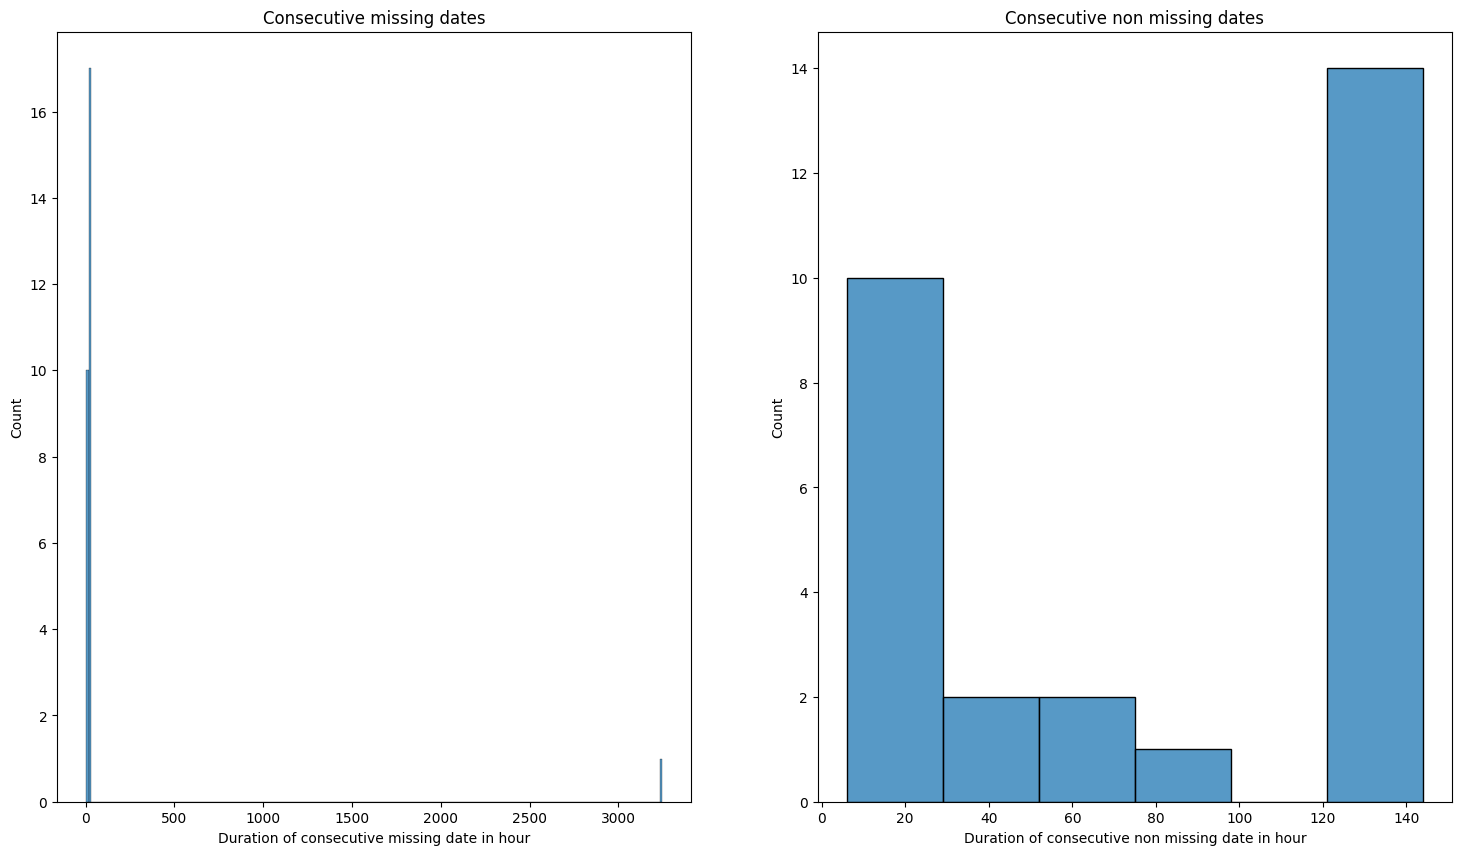

Missing values analysis for unit A2 DE PARC EOLIEN EN MER DE LA BAIE DE ST-BRIEUC
The dataset contain 6201 values


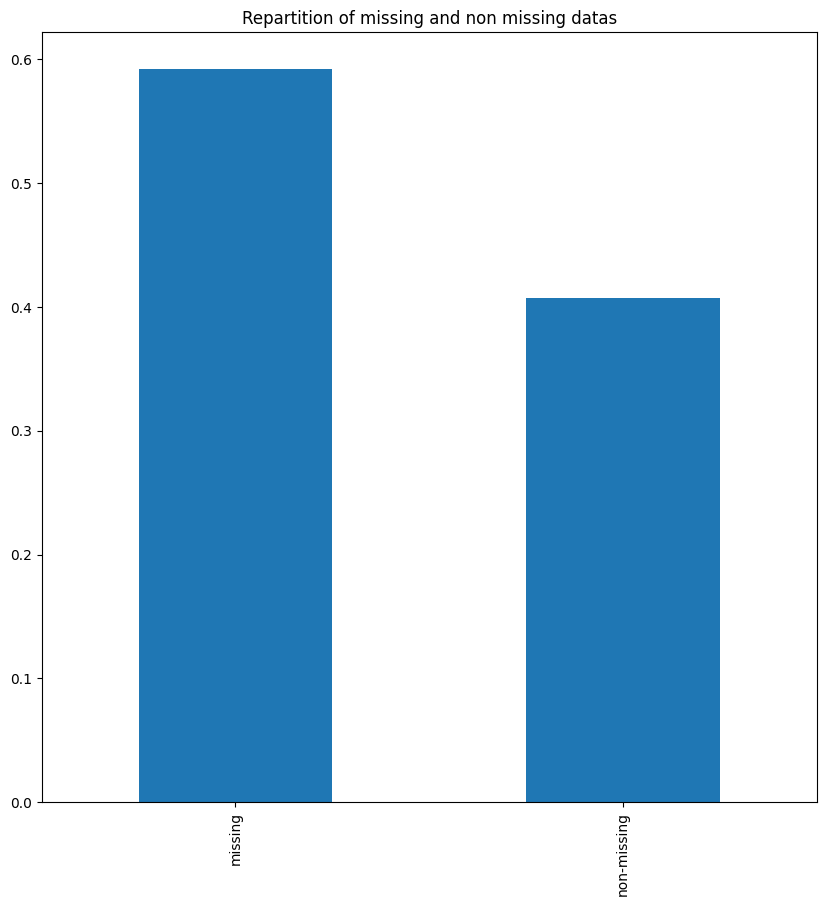

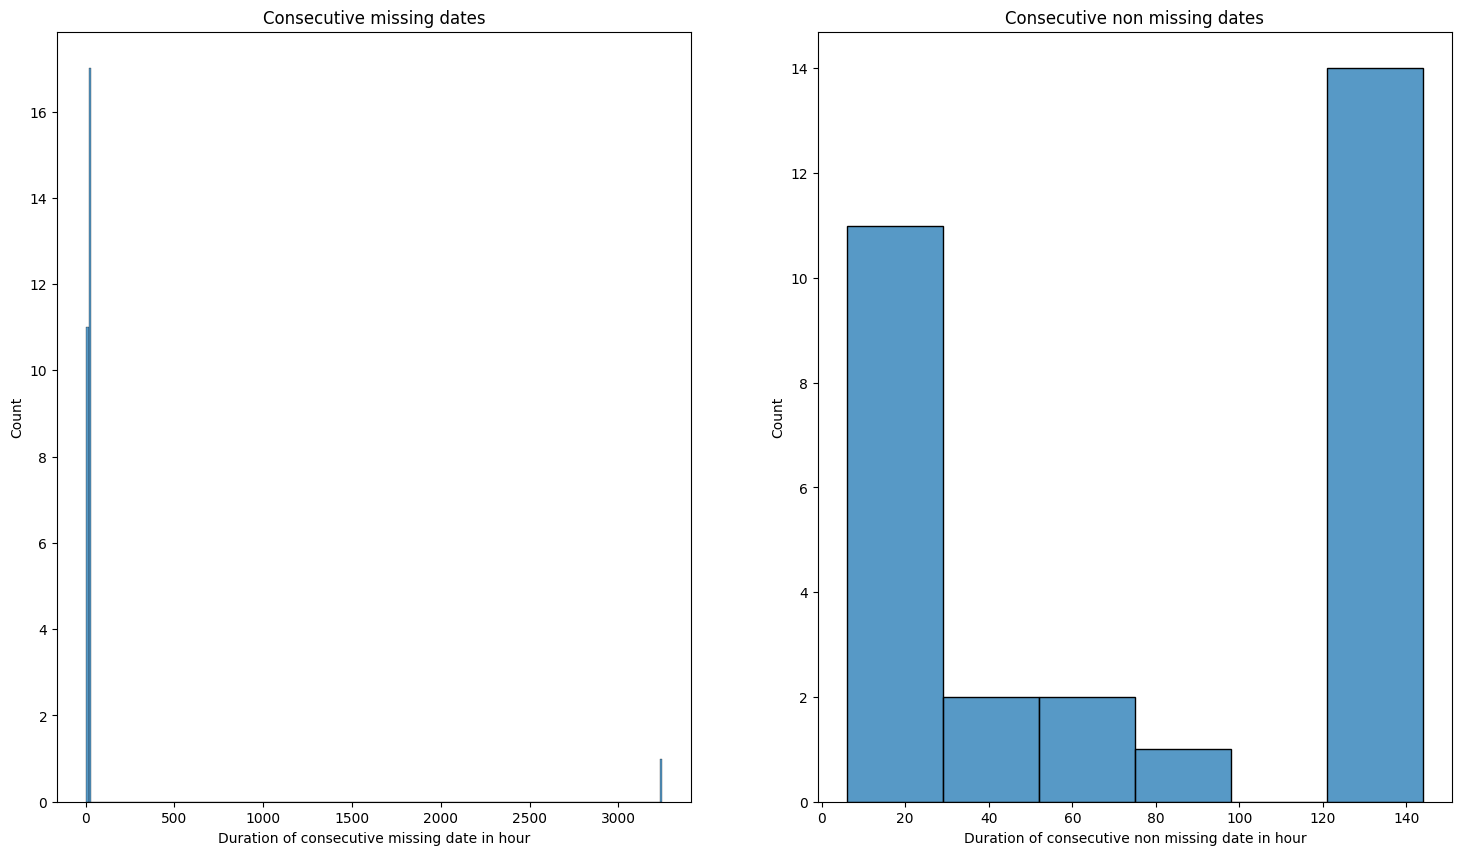

In [4]:
################################################################################
# 3/ Show missing datas characteristics for each wind offshore generation unit #
################################################################################

# Extract eic codes for wind offshore generation units
wind_production_types = ["WIND_ONSHORE", "WIND_OFFSHORE"]
eic_codes = ressource_2_units.loc[ressource_2_units["production_type"].isin(wind_production_types), "eic_code"]

# Iterate over the eic codes
for eic_code in eic_codes:
    # Filter data for the given eic code
    gen_data = ressource_2_gen_data.loc[ressource_2_gen_data["eic_code"] == eic_code, :]

    # Print the generation unit
    print(f"Missing values analysis for unit {ressource_2_units.loc[ressource_2_units['eic_code'] == eic_code, 'name'].values[0]}")

    # Print the number of data points in each gen dataset
    dt_columns = ["start_date", "end_date"]
    gen_data_dt_complete = construct_time_consistent_df(gen_data, dt_columns)
    print(f"The dataset contain {len(gen_data_dt_complete)} values")

    # Plot the repartition of missing and non missing datas
    plot_missing_dates_repartition(gen_data, "start_date")

    # Plot the repartition of missing and non missing dates
    plot_consecutive_time_periods(gen_data, "start_date")

The Fecamp generation unit seems promissing, let's plot its data :

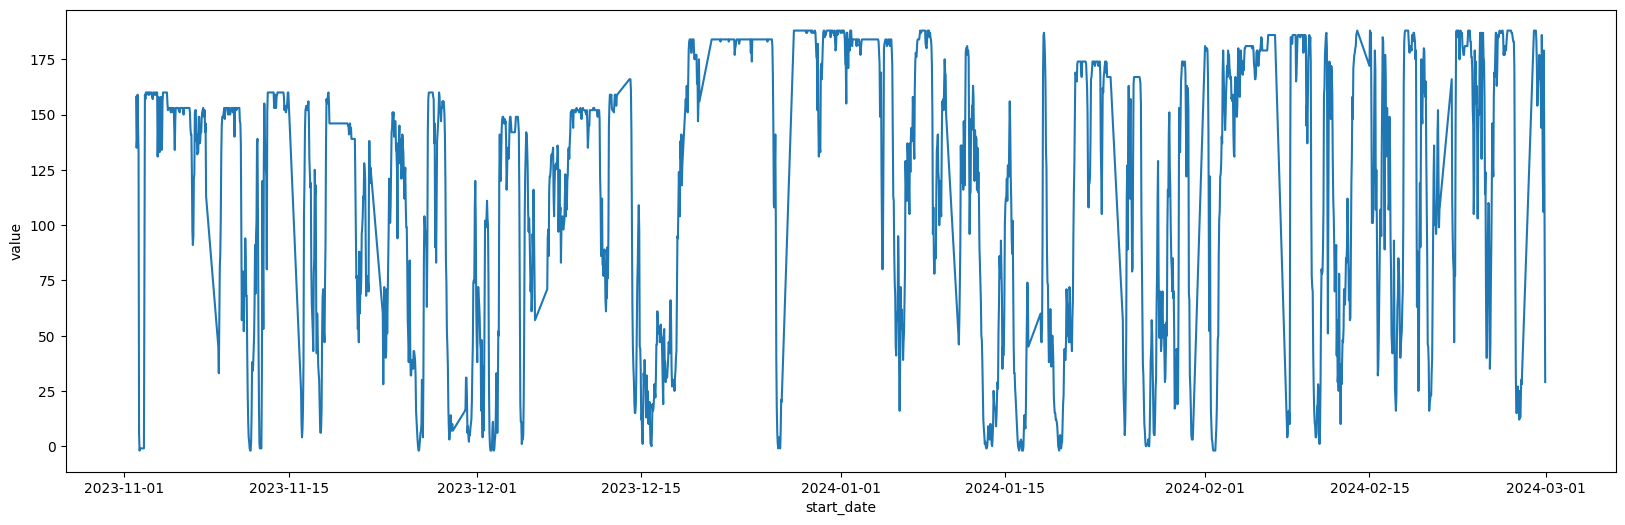

In [10]:
# Set the parameters
ressource_nb = 2
start_date = "2022-06-01 00:00:00" # Note: don't modify the start & end date for following requests
end_date = "2024-03-01 00:00:00"
eic_code = "17W0000014455708"
production_type = None
production_subtype = None

# Download generation data: don't forget to set the api_delay_bypass to true in the params in this case,
# and to reset it to false if you know that you will download fresh data from the api
gen_data = get_rte_data(ressource_nb = ressource_nb,
                        start_date = start_date,
                        end_date = end_date,
                        eic_code = eic_code,
                        production_type = production_type,
                        production_subtype = production_subtype)

# Constuct the time consistent df
dt_columns = ["start_date", "end_date"]
gen_data_dt = construct_time_consistent_df(gen_data, dt_columns)

# Plot
plt.figure(figsize = (20, 6))
sns.lineplot(data = gen_data_dt, x = "start_date", y = "value")
plt.show()